### Personality and It's Transformations ###

An analysis of prof. Jordan Peterson's collection of lectures from University of Toronto personality course.

Lectures in video form provided at: https://www.youtube.com/playlist?list=PL22J3VaeABQAOhH1CLMNnMl2R-O1abW1T     |    More about prof. Peterson at https://www.jordanbpeterson.com/

---

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

from constants import *

import umap
import hdbscan
from collections import Counter

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Load the data</h4> 
</div>

In [3]:
with open(f'{OUTPUT_FOLDER}\{FINAL_CAPTIONS_FILE_NAME}', 'r', encoding='utf-8') as f:
    data = f.readlines()
data = [sent.replace('\n', '') for sent in data]

In [4]:
data[:5]

['Well, after all that.',
 'So, welcome to Psychology 230.',
 'Nice to see you all here.',
 'So, what I’m going to do today—how I’m going to start—is I’m going to give you an overview of the content of the course',
 'and then I’ll give you an overview of the class requirements right at the end.']

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Check the model</h4> 
</div>

***Sentence-BERT*** - a modification of the pretrained BERT network will be used for sentence embeddings.   
Paper on Sentence-BERT can be found at https://arxiv.org/abs/1908.10084

In [5]:
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

In [6]:
model.max_seq_length

256

The default model has length 256, but it must be increased because our longest sentence has 315 words and the number of tokens will be even greater. A max value of 512 will be set.

In [7]:
model.max_seq_length = SENT_LENGTH

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Make basic embeddings</h4> 
</div>

In [8]:
%%time

embeddings = model.encode(data, batch_size=128, convert_to_numpy=True, show_progress_bar=True)

Batches: 100%|██████████| 48/48 [02:05<00:00,  2.61s/it]

Wall time: 2min 5s


In [9]:
print(embeddings.shape, type(embeddings))
embeddings

(6144, 384) <class 'numpy.ndarray'>


array([[-0.042135  , -0.00991856,  0.0509069 , ..., -0.05108282,
         0.00194738,  0.04068652],
       [ 0.00552613, -0.02808623, -0.04600509, ...,  0.05598029,
         0.00492619, -0.03378102],
       [-0.03447534, -0.04569017,  0.06889623, ...,  0.10120902,
         0.02934075,  0.04402328],
       ...,
       [ 0.0612012 ,  0.02968354, -0.00442004, ..., -0.0268718 ,
         0.04280903,  0.10524604],
       [-0.11883845,  0.04829872, -0.00254809, ...,  0.12640946,
         0.04654904, -0.01571726],
       [-0.11883845,  0.04829872, -0.00254809, ...,  0.12640946,
         0.04654904, -0.01571726]], dtype=float32)

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Dimensionality reduction</h4> 
</div>

***UMAP*** is a dimensionality reduction algorytm published in 2020.    
The original paper and more info about UMAP can be found here: https://arxiv.org/pdf/1802.03426.pdf

In [121]:
neighbors = 10
components = 5

`n_neighbors` regulates whether UMAP should focus more on global or lobal scructures of the data. Low values of n_neighbors will force UMAP to concentrate on very local structure (it will find patterns in local small sections not seeing the big picture), while large values will push UMAP to look at larger neighborhoods (focusing on the big picture) losing fine distinct features of local, smaller neighborhoods. You can think of this like literally focusing on your neighbors when you live for example on a country side. If n_neighbors is small someone can describe you  based on your membership to only your small community (e.g. people from your street). If n_neighbors is large someone can describe you based on the judgement from people from the whole city or state.

`n_components` the dimensionality of the reduced dimension space we will be embedding the data into.

### Training the sample model ###

In [122]:
%%time

umap_embeddings = umap.UMAP(
    n_neighbors = neighbors,
    n_components = components,
    n_epochs = 5000,
    min_dist = 0.0,
    learning_rate = 0.4,
    verbose = True,
    metric = 'cosine').fit_transform(embeddings)

UMAP(angular_rp_forest=True, learning_rate=0.4, metric='cosine', min_dist=0.0, n_components=5, n_epochs=5000, n_neighbors=10, verbose=True)
Sun Jan  8 22:07:10 2023 Construct fuzzy simplicial set
Sun Jan  8 22:07:10 2023 Finding Nearest Neighbors
Sun Jan  8 22:07:10 2023 Building RP forest with 9 trees
Sun Jan  8 22:07:12 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	 7  /  13
	 8  /  13
	Stopping threshold met -- exiting after 8 iterations
Sun Jan  8 22:07:12 2023 Finished Nearest Neighbor Search
Sun Jan  8 22:07:12 2023 Construct embedding


Epochs completed: 100%| ██████████ 5000/5000 [01:03]


Sun Jan  8 22:08:16 2023 Finished embedding
Wall time: 1min 6s


In [123]:
print(umap_embeddings.shape, type(umap_embeddings))
embeddings

(6144, 5) <class 'numpy.ndarray'>


array([[-0.042135  , -0.00991856,  0.0509069 , ..., -0.05108282,
         0.00194738,  0.04068652],
       [ 0.00552613, -0.02808623, -0.04600509, ...,  0.05598029,
         0.00492619, -0.03378102],
       [-0.03447534, -0.04569017,  0.06889623, ...,  0.10120902,
         0.02934075,  0.04402328],
       ...,
       [ 0.0612012 ,  0.02968354, -0.00442004, ..., -0.0268718 ,
         0.04280903,  0.10524604],
       [-0.11883845,  0.04829872, -0.00254809, ...,  0.12640946,
         0.04654904, -0.01571726],
       [-0.11883845,  0.04829872, -0.00254809, ...,  0.12640946,
         0.04654904, -0.01571726]], dtype=float32)

### Saving the model ###

In [124]:
with open(f'{MODELS_FOLDER}\{SAMPLE_UMAP_MODEL_NAME}.npy', 'wb') as f:
    np.save(f, umap_embeddings)

In [125]:
with open(f'{MODELS_FOLDER}\{SAMPLE_UMAP_MODEL_NAME}.npy', 'rb') as f:
    umap_model = np.load(f)

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Clustering</h4> 
</div>

***HDBSCAN*** is a hierarchical clustering algorithm. It returns a good enough clustering straight away with little parameter tuning.   
More information can be found here:
https://nbviewer.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/How%20HDBSCAN%20Works.ipynb  
Link to offical repository: https://github.com/scikit-learn-contrib/hdbscan 

And comparison between DBSCAN and other clustering methods: https://nbviewer.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb


In [147]:
min_cluser_size = 30
min_samples = 3

`min_cluster_size` - the minimum size a final cluster can be.   
`min_samples` - the higher this is, the more points are going to be treeted as outliers.

In [148]:
%%time

clusters = hdbscan.HDBSCAN(
    min_cluster_size = min_cluser_size,
    metric = 'euclidean',
    min_samples = min_samples,
    cluster_selection_epsilon = 0.1,
    cluster_selection_method = 'leaf',
    leaf_size = 35,
    algorithm = 'best').fit(umap_embeddings)


Wall time: 226 ms


In [151]:
def cluster_statistics(clusters:hdbscan.hdbscan_.HDBSCAN) -> pd.DataFrame:
    """Print basic statistic about a given structure of clusters
        - number of unique clusters
        - number of all points
        - number of points treeted as outliers (noise)
        This also plots distribution of the clusters

    Args:
        clusters (hdbscan.hdbscan_.HDBSCAN): HDBSCAN clusters 

    Returns:
        pd.DataFrame: a dataframe with basic statistics
        Additionaly a plot of cluster distribution in shown.
    """

    # empty dataframe
    summary = pd.DataFrame(columns = ['metric', 'value'])
    summary.at[0, 'metric'] = 'Number of unique clusters'

    # get number of all clusters in first row
    summary.at[0, 'value'] = len(set(clusters.labels_))

    # count number of points in each cluster (sentences in each group)
    cnt = Counter()
    cnt.update(clusters.labels_)

    # total number of all sentences
    sum_of_all_elements = sum([entry[1] for entry in cnt.most_common()])
    # number of outlier sentences
    sum_of_empty_elements = [entry[1] for entry in cnt.most_common() if entry[0] == -1][0]

    # get total number of all sentences and number of outliers into the dataframe
    summary.at[1, 'metric'] = 'Number of all sentences'
    summary.at[1, 'value'] = sum_of_all_elements
    
    summary.at[2, 'metric'] = 'Number of noise'

    # calculate how many percent of total sentences are the outlier sentences
    percentage = '{:.4}'.format(str((sum_of_empty_elements/sum_of_all_elements)*100))
    summary.at[2, 'value'] = f'{sum_of_empty_elements} ({percentage}%)'

    # plot the distribution showing number of sentences in each cluster
    x, y= zip(*cnt.most_common())
    plt.bar(x, y);
    
    return summary

,metric,value
0,Number of unique clusters,85
1,Number of all sentences,6144
2,Number of noise,1608 (26.1%)


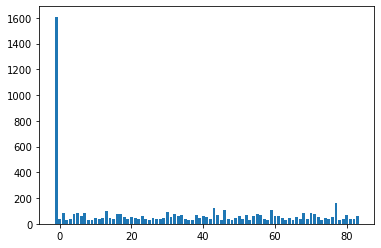

In [152]:
cluster_statistics(clusters)

<div class="tomcolor8">  
<h4 style="background:#135e96; color:white ;font-size:15px;line-height:1em; text-align:left; padding: 20px">
      Visualisation</h4> 
</div>

In [119]:
%%time

umap_3d = umap.UMAP(
    n_neighbors = neighbors,
    n_components = 3,
    min_dist = 0.5,
    n_epochs = 9000,
    learning_rate = 0.4,
    metric = 'cosine').fit_transform(embeddings)

Wall time: 2min 40s


In [120]:
umap_3d

array([[-10.255381 ,  -0.7764898,  11.232977 ],
       [-11.237078 ,  -4.3988147,  17.254658 ],
       [-10.759359 ,  -0.4573234,  11.018052 ],
       ...,
       [-11.449824 ,  -2.2520685,  12.606069 ],
       [ -9.170087 ,  -0.5147373,   9.051618 ],
       [ -9.340469 ,  -0.5771049,   9.162561 ]], dtype=float32)